In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

### Herdando da classe keras.models.Model.

Neste exemplo iremos definir e criar uma instância da classe `WideAndDeepModel`, que nos dá um modelo equivalente ao que acabamos de construir com a API Funcional. 

Depois de instanciado um objeto desta classe, podemos então compilá-lo, avaliá-lo e usá-lo para fazer previsões, exatamente como acabamos de fazer.

### Carregando o conjunto de dados para regressão. 

+ Vamos usar o conjunto de dados habitacional da Califórnia e criar um regressor com uma rede neural.

+ Depois de carregar os dados, dividimos em um conjunto de treinamento, um conjunto de validação e um conjunto de teste, e padronizamos todos os atributos.

In [3]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Definição da classe `WideAndDeepModel`.

+ A classe `WideAndDeepModel` herda de `keras.models.Model`.
+ No construtor, criamos todas as camadas necessárias.
+ No método `call`, realizamos os cálculos.


Este exemplo se parece muito com o que utilizou a API Funcional, exceto que não é necessário instanciar as entradas (`Input`), apenas usamos o parâmetro de entrada passado para o método `call()` e separamos a criação das camadas no construtor de seu uso no método `call()`.

In [8]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation, name="main_output")
        self.hidden2 = keras.layers.Dense(units, activation=activation, name="aux_output")
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

### Instanciando um objeto da classe `WideAndDeepModel`.

In [9]:
model = WideAndDeepModel()

### Compilando o modelo.

+ A mesma função de perda é usada para ambas as saídas.

In [10]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

### Separando os atributos e treinando o modelo.

In [11]:
# Separando os atributos.
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

# Treinando o modelo.
history = model.fit((X_train_A, X_train_B), 
                    (y_train, y_train), 
                    epochs=20,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid))
                   )

Epoch 1/20
363/363 [==============================] - 4s 6ms/step - loss: 2.0984 - output_1_loss: 1.8521 - output_2_loss: 4.3151 - val_loss: 1.5430 - val_output_1_loss: 0.9144 - val_output_2_loss: 7.2005
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.9781 - output_1_loss: 0.7778 - output_2_loss: 2.7815 - val_loss: 1.3118 - val_output_1_loss: 0.6824 - val_output_2_loss: 6.9755
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.8065 - output_1_loss: 0.6685 - output_2_loss: 2.0489 - val_loss: 1.2622 - val_output_1_loss: 0.6458 - val_output_2_loss: 6.8096
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7198 - output_1_loss: 0.6114 - output_2_loss: 1.6951 - val_loss: 1.2022 - val_output_1_loss: 0.6136 - val_output_2_loss: 6.5002
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6700 - output_1_loss: 0.5756 - output_2_loss: 1.5195 - val_loss: 1.1395 - val_output_1_loss: 0.5936 - val_ou

### Histórico de perda do modelo.

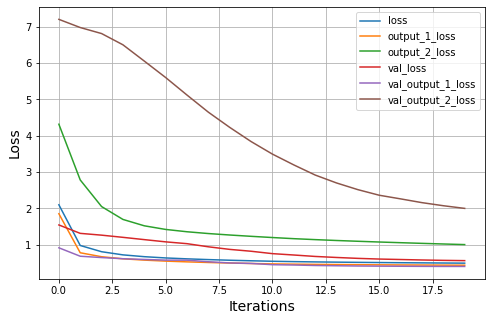

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

### Avaliando o modelo.

In [12]:
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

162/162 [==============================] - 0s 3ms/step - loss: 0.4822 - output_1_loss: 0.4278 - output_2_loss: 0.9714


### Realizando predições com o modelo.

In [14]:
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 29ms/step
